## LSTM 

In [1]:
## for data
import json
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
from nltk.tokenize import word_tokenize
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

/home/dee/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

dtf = pd.DataFrame(lst_dics, columns=['headline','category'])


dtf['category'].unique()

dtf

## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH', 'BUSINESS', 'SCIENCE']) ][["headline","category"]]
## rename columns
#dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

dtf = dtf.replace("TECH", "SCIENCE&TECH")
dtf = dtf.replace("SCIENCE", "SCIENCE&TECH")

dtf['category'].unique()

dtf['category'].unique()

array(['ENTERTAINMENT', 'POLITICS', 'BUSINESS', 'SCIENCE&TECH'],
      dtype=object)

In [3]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    no_integers = [x for x in lst_text if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    text = " ".join(no_integers)
    return text

    

In [22]:
#lst_stopwords = nltk.corpus.stopwords.words("german")
#lst_stopwords

#nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

#nltk.download('wordnet')
dtf["text_clean"] = dtf["headline"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()
dtf.to_csv('data_cleaned.csv')

In [5]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dtf['text_clean'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(dtf['text_clean'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Found 28915 unique tokens.
Shape of data tensor: (58994, 250)


In [20]:
lb = LabelEncoder()
Y = lb.fit_transform(dtf['category'])

(53094, 250) (53094,)
(5900, 250) (5900,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 13)                1313      
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
747/747 [==============================] - 394s 521ms/step - loss: 0.6494 - accuracy: 0.7662 - val_loss: 0.4053 - val_accuracy: 0.8546
Epoch 2/5
747/747 [==============================] -

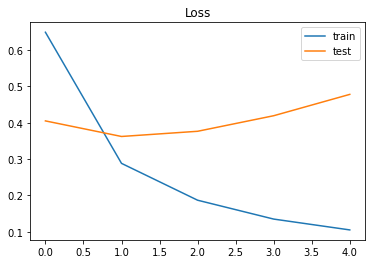

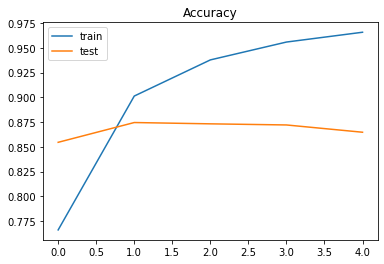

In [6]:



from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(dtf['category'])

#Y = pd.get_dummies(dtf['category']).values
#print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#The first layer is the embedded layer that uses 100 length vectors to represent each word.
#SpatialDropout1D performs variational dropout in NLP models.
#The next layer is the LSTM layer with 100 memory units.
#The output layer must create 13 output values, one for each class.
#Activation function is softmax for multi-class classification.
#Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

dtf['category'].unique()

dtf['text_clean'].iloc[10]

new_complaint = ['justin timberlake visit texas school shooting victim']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['ENTERTAINMENT', 'POLITICS', 'BUSINESS', 'SCIENCE&TECH']
print(pred, labels[np.argmax(pred)])

padded

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [9]:
model.save("model/LSTM.h5")

In [12]:
#Load KERAS model
from keras.models import load_model

# load model
model = load_model('model/LSTM.h5')

In [ ]:

predictions, raw_outputs = model.predict(["Some arbitary sentence"])

In [21]:
lb.classes_

array(['BUSINESS', 'ENTERTAINMENT', 'POLITICS', 'SCIENCE&TECH'],
      dtype=object)